In [1]:
# import numpy as np
# import matplotlib.pyplot as plt

# # ==== 假设的能量 bins 与对应概率 ====
# bins = np.array([0,   10,   20,  30, 40,  50,    60,   70, 80])  # keV
# pdf = np.array([0.01, 0.09, 0.2, 0,  0.4, 0.1, 0.15, 0.05])  # 每个区间的相对概率

# # 归一化
# pdf = pdf / pdf.sum()

# # 计算累积分布函数（CDF）
# cdf = np.cumsum(pdf)
# bin_centers = (bins[:-1] + bins[1:]) / 2

# # ==== 画图 ====
# fig, ax = plt.subplots(2, 1, figsize=(6, 5))

# # 上图：PDF（概率密度）
# ax[0].bar(bin_centers, pdf, width=8, color='skyblue', edgecolor='k')
# ax[0].set_title('PDF: Energy Probability Distribution')
# ax[0].set_xlabel('Energy (keV)')
# ax[0].set_ylabel('Probability')

# # 下图：CDF（累积分布函数）
# ax[1].step(bin_centers, cdf, where='mid', color='orange', label='CDF')
# ax[1].set_xlabel('Energy (keV)')
# ax[1].set_ylabel('Cumulative Probability')
# ax[1].set_ylim(0, 1.05)

# # 示意几个随机数 u
# u = np.array([0.05, 0.75, 0.25, 0.55, 0.85])
# idx = np.searchsorted(cdf, u)

# # 在CDF图上画出这些随机数与对应能量区间
# for ui, i in zip(u, idx):
#     ax[1].hlines(ui, 0, bin_centers[i], color='gray', linestyle='--')
#     ax[1].vlines(bin_centers[i], 0, ui, color='gray', linestyle='--')
#     ax[1].plot(bin_centers[i], ui, 'ro')
#     ax[1].text(bin_centers[i]+1, ui+0.02, f'idx={i}', fontsize=9)

# plt.tight_layout()
# plt.show()

# print("随机数 u:", u)
# print("cdf:", cdf)
# print("对应索引 idx:", idx)
# print("对应能量 bin centers:", bin_centers[idx])


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from poisson_signal_generator_utils import generate_signal, build_energy_bins_and_pdf

## 待做：找一找 asci 本底噪声电子噪声的信号波形，来做模拟
 

# 1) 读取理论光谱文件,

data = np.loadtxt('spectrum_file/spek_120.txt', 
                  skiprows=1)     # skiprows=1，跳过第一行
energies = data[:,0]              # 能量点，单位 keV  
values   = data[:,1]              # 对应归一化强度 N[keV cm^2 mAs]^-1 @ 1 meter
bins, pdf, dE = build_energy_bins_and_pdf(energies, 
                                          values) # 构建坐标轴 计算入射计数率 λ（counts/s）# ---------- 用中心能量构造“边界” -> 保证 bins 长度 = N+1, pdf 长度 = N ----------

 
# 2) 光源物理参数
Voltage = 120                   # 管压              [kvp]
I_mA   = 100.0                   # 管电流            [mA] 
r_m    = 0.40                   # 源到探测器距离     [m]
pixel_length  = 340e-6           # 单像素尺寸340um，  [cm]  

# 2-1) 光子信号在芯片上的假设参数
pulse   = 1e-9                 # 信号脉宽 15ns      [s]
amp    = 1                         # 探测器对光源的放大系数

# 3） 芯片参数设置
delta_t = 1e-10                    # 采样帧频率 1ns     [s]
integral_time = 400e-6             # 信号积分时间 400us [s]

# 4) 计算参数
A_cm2  = (pixel_length * 100.0)**2    # m->cm，面积用 cm^2
rate = np.sum(values * dE * I_mA * (1.0/r_m)**2 * A_cm2)
chip_rate = amp * rate          # 进入芯片的计数率

print("lambda*tau =", chip_rate * pulse)  # 无量纲

lambda*tau = 0.17399776424420155


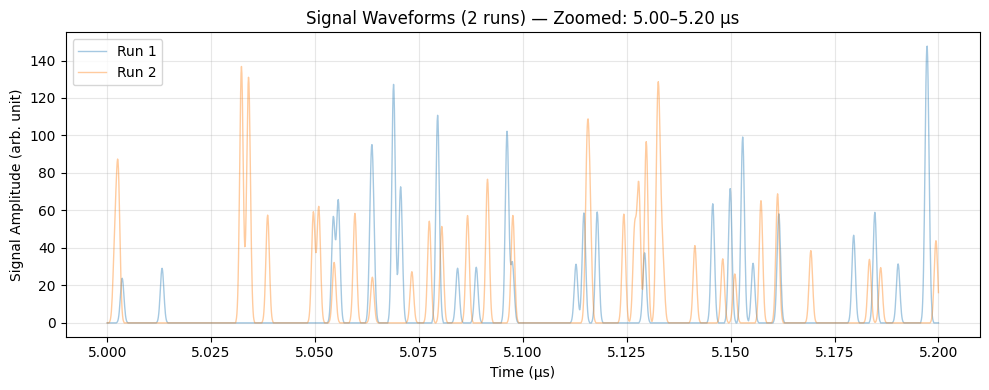

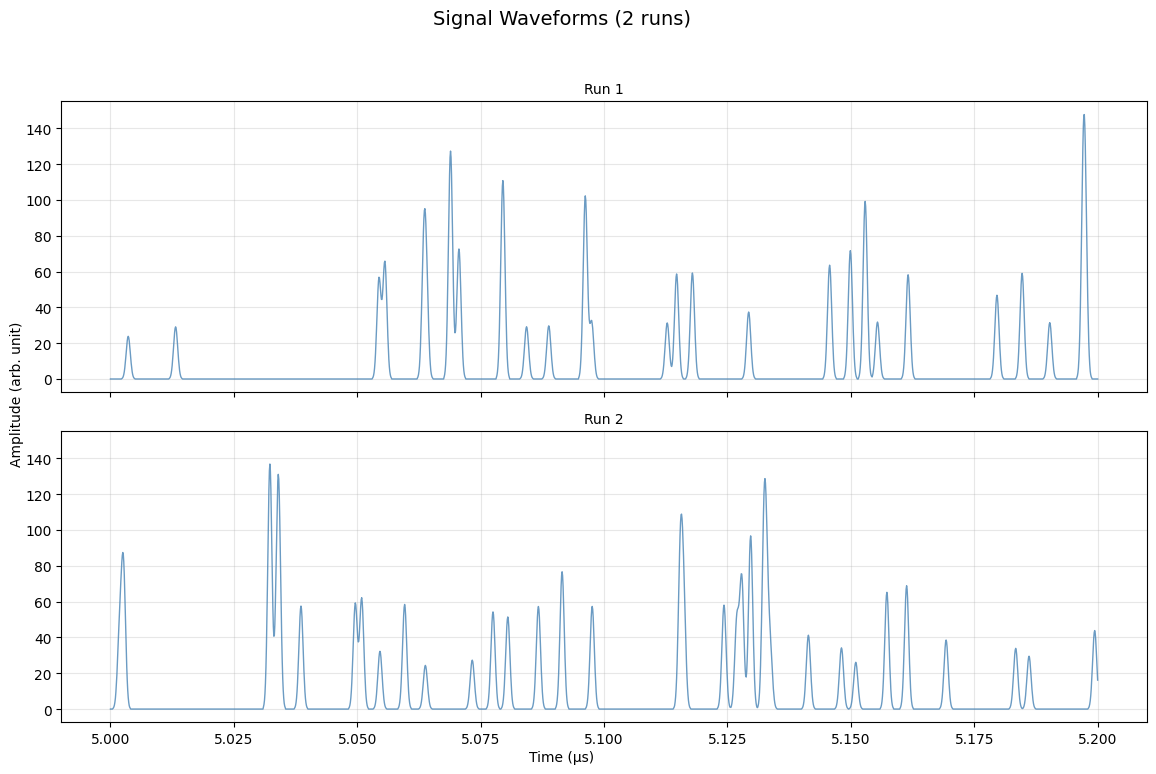

In [3]:
from poisson_signal_generator_utils import make_threshold_grid_from_energy, spectrum_from_signal
from poisson_signal_generator_utils import plot_signals_over_time, plot_signals_grid

# -------- 固定全局阈值轴（重要！）--------
gain = 1.0                 # 若要物理电压，设成 V/keV，例如 3.5e-3 V/keV
thr_grid = make_threshold_grid_from_energy(bins, gain=gain, n_thr=256)

# 5） 根据 归一化的 谱，产生时间信号
n_runs = 2   # 重复次数
integrals, differentials = [], []
signals = []  # 存每次生成的波形
 

for _ in range(n_runs):
    t, sig, times, amps = generate_signal(bins, pdf, chip_rate, 
                                      integral_time, 
                                      pulse,     # 脉宽 
                                      delta_t,              # 1ns
                                      gain=1.0,
                                      pulse_shape='gauss'
                                      )
    integ, diff = spectrum_from_signal(sig, thr_grid)
    integrals.append(integ)
    differentials.append(diff) 
    signals.append(sig)     # ✅ 保存每次的波形

integral_avg     = np.mean(integrals, axis=0)
differential_avg = np.mean(differentials, axis=0)

# ✅ 画出所有信号叠加图
# plot_signals_over_time(t, signals, max_plot=10, alpha=0.4)
plot_signals_over_time(t, signals, max_plot=5, zoom=(5.0, 5.2))

plot_signals_grid(t, signals, max_plot=4, zoom=(5.0, 5.2))

In [4]:
from poisson_signal_generator_utils import report_source_max, analyze_peaks_above_threshold, quick_overlap_metrics

# 先看源最大幅度（单位与 gain 一致；gain=1 时就是 keV 等效）
report_source_max(amps, gain=1.0)

# 统计“>120”的峰：列出 top 5 个峰的时间、峰值、贡献事件数等
peaks = analyze_peaks_above_threshold(
    t, sig, times, amps,
    threshold=120.0,
    pulse_width=pulse,          # 你的脉宽
    pulse_shape='gauss',         # 或 'gauss'（若你用高斯脉冲）
    top_k=5,
    gain=1.0
)

# 看整体重叠强度
quick_overlap_metrics(times, pulse_width=pulse, rate=chip_rate)

[源最大幅度] max(amps) = 118.995  (单位 = keV等效)

[超过阈值 120.0 的峰统计] 共 2449 个片段，展示 top 5：
  #1: t_peak=132.807 μs, v_peak=258.356, n_contrib=4, single_max_amp=116.532
  #2: t_peak=149.145 μs, v_peak=250.952, n_contrib=3, single_max_amp=115.905
  #3: t_peak=54.411 μs, v_peak=246.220, n_contrib=5, single_max_amp=103.470
  #4: t_peak=292.766 μs, v_peak=243.116, n_contrib=5, single_max_amp=70.588
  #5: t_peak=138.915 μs, v_peak=240.572, n_contrib=4, single_max_amp=109.858
[λτ 与重叠比例]  λτ≈0.174， 经验 overlap_frac≈0.160


0.1596662789528856

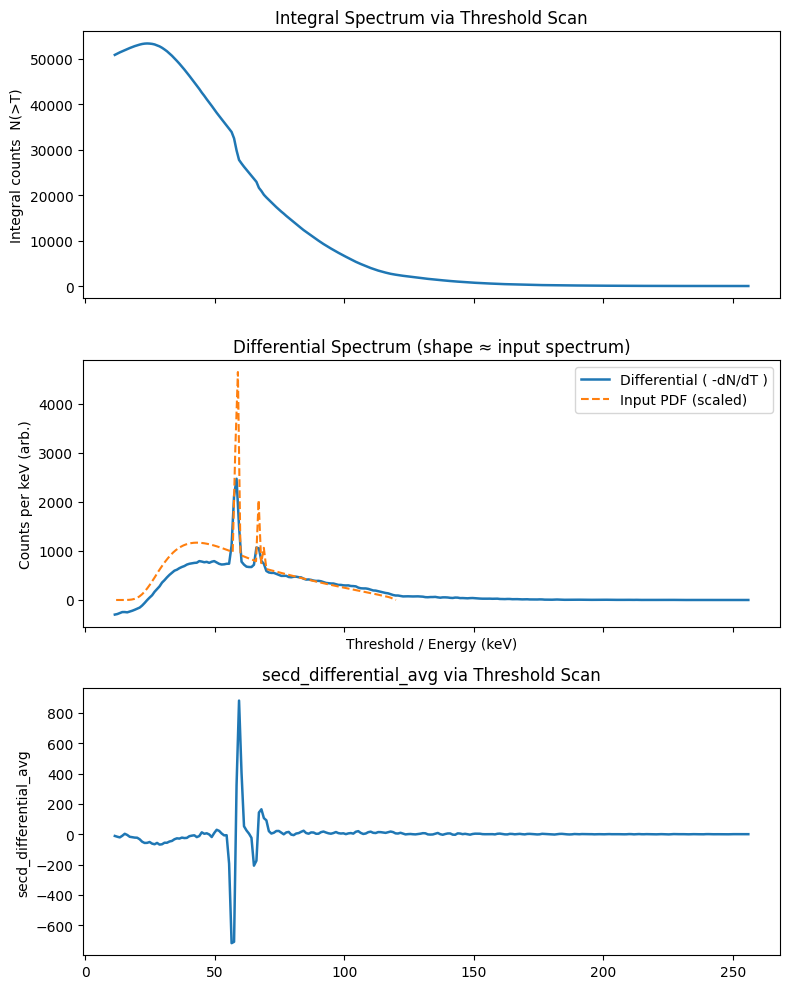

In [11]:
energy_axis = thr_grid   # keV（在你的 generate_signal 里 gain=1.0）

secd_differential_avg = - np.gradient( differential_avg, energy_axis )

# --- 画图：积分谱 & 微分谱（与输入pdf作形状对比）---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# 积分谱（阈值越高，计数越少）
ax1.plot(energy_axis, integral_avg, lw=1.8)
ax1.set_ylabel('Integral counts  N(>T)')
ax1.set_title('Integral Spectrum via Threshold Scan')

# 微分谱（应近似输入能谱形状；仅差一个尺度因子）
ax2.plot(energy_axis, differential_avg, lw=1.8, label='Differential ( -dN/dT )')

# 可选：把输入 pdf 归一后缩放到可见范围作对比（仅形状对比）
# 这里简单按最大值对齐
orig_centers = (bins[:-1] + bins[1:]) / 2
# pdf_norm = pdf / pdf.max() * differential_avg.max() if differential_avg.max() > 0 else pdf
pdf_norm = pdf * rate *3.8e-4
ax2.plot(orig_centers, pdf_norm , '--', label='Input PDF (scaled)')

ax2.set_xlabel('Threshold / Energy (keV)')
ax2.set_ylabel('Counts per keV (arb.)')
ax2.set_title('Differential Spectrum (shape ≈ input spectrum)')
ax2.legend()

# 积分谱（阈值越高，计数越少）
ax3.plot(energy_axis, secd_differential_avg, lw=1.8)
ax3.set_ylabel('secd_differential_avg')
ax3.set_title('secd_differential_avg via Threshold Scan')
 

plt.tight_layout()
plt.show()


In [ ]:
# (1) 光谱（能量分布）
plt.subplot(2,1,1)
# plt.plot((bins[:-1] + bins[1:]) / 2, pdf, color='purple')
plt.plot(bins , pdf, color='purple')
plt.xlabel('Energy (keV)')
plt.ylabel('Relative Intensity')
plt.title('Input X-ray Spectrum (PDF)')

# (2) 时间波形
plt.subplot(2,1,2)
plt.plot(t*1e6, sig_avg, label='Input Pulses')
plt.axhline(25, color='r', linestyle='--', label='~25 keV Threshold')
plt.xlabel('Time (μs)')
plt.ylabel('Amplitude (arb.)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from poisson_signal_generator_utils import count_crossings

# --- 阈值扫描参数 ---
dt = t[1] - t[0]                   # 采样间隔
thr_min = 1.0
# thr_max = 257
thr_max = sig_avg.max() #* 1.05
n_thr   = 256                      # 阈值点数（可调）
thr_vals = np.linspace(thr_min, thr_max, n_thr)



# --- 扫描阈值，得到积分谱 N(>T) ---
integral_counts = np.array([count_crossings(sig_avg, thr) for thr in thr_vals])

# --- 微分谱：对积分谱随阈值做负梯度 ---
# 用梯度近似 -dN/dT（注意单位 ~ counts/幅度）
differential = -np.gradient(integral_counts, thr_vals)

# 如果你的 gain=1，那么“幅度=能量(keV)”；否则这里可做 thr_vals/gain 的能量轴换算
energy_axis = thr_vals  # keV（在你的 generate_signal 里 gain=1.0）

# --- 画图：积分谱 & 微分谱（与输入pdf作形状对比）---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# 积分谱（阈值越高，计数越少）
ax1.plot(energy_axis, integral_counts, lw=1.8)
ax1.set_ylabel('Integral counts  N(>T)')
ax1.set_title('Integral Spectrum via Threshold Scan')

# 微分谱（应近似输入能谱形状；仅差一个尺度因子）
ax2.plot(energy_axis, differential, lw=1.8, label='Differential ( -dN/dT )')

# 可选：把输入 pdf 归一后缩放到可见范围作对比（仅形状对比）
# 这里简单按最大值对齐
orig_centers = (bins[:-1] + bins[1:]) / 2
pdf_norm = pdf / pdf.max() * differential.max() if differential.max() > 0 else pdf
ax2.plot(bins, pdf_norm , '--', label='Input PDF (scaled)')

ax2.set_xlabel('Threshold / Energy (keV)')
ax2.set_ylabel('Counts per keV (arb.)')
ax2.set_title('Differential Spectrum (shape ≈ input spectrum)')
ax2.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# energies: 形如 [12,13,...,120] keV 的中心点
# values:   同长度的 N_i，单位 [keV·cm^2·mAs]^-1 @ 1 m
# 示例：energies, values = load_spectrum('spek_120.txt')  # 你前面已经有

# 1) 构造能量 bin 边界与步长
if np.allclose(np.diff(energies), energies[1]-energies[0]):
    dE = np.diff(np.concatenate([energies, [energies[-1] + (energies[1]-energies[0])]]))
else:
    # 不等间隔：用相邻中心点做边界
    mid = (energies[:-1] + energies[1:]) / 2
    edges = np.empty(len(energies) + 1)
    edges[1:-1] = mid
    edges[0] = energies[0] - (mid[0] - energies[0])
    edges[-1] = energies[-1] + (energies[-1] - mid[-1])
    dE = np.diff(edges)

# 2) 物理参数（按需要替换）
I_mA   = 20.0           # 管电流 mA（连续透视时）
r_m    = 0.40           # 源到探测器距离（m）
A_cm2  = 340e-4*340e-4     # 例如单像素 0.5 mm × 0.5 mm = 0.05 cm × 0.05 cm
eta    = np.ones_like(values)  # 暂时不考虑效率时取 1

# 3) 计算入射计数率 λ（counts/s）
rate = np.sum(values * dE * I_mA * (1.0/r_m)**2 * A_cm2 * eta)

# 4) 生成 pdf（只要形状）
pdf = values * dE
pdf = pdf / pdf.sum()

# 5) 构造 bins（边界）传给 generate_signal
# 若 energies 是中心点：
bin_edges = np.empty(len(energies) + 1)
bin_edges[1:-1] = (energies[:-1] + energies[1:]) / 2
bin_edges[0] = energies[0] - (bin_edges[1] - energies[0])
bin_edges[-1] = energies[-1] + (energies[-1] - bin_edges[-2])

# 6) 调用你的生成函数
t, sig, times, amps = generate_signal(
    spectrum_bins=bin_edges,
    spectrum_pdf=pdf,
    rate=rate,                 # 这里就是“真实计数率/像素”
    T_total=400e-6,
    pulse_width=25e-9,
    dt=1e-9,
    gain=1.0
)

print(f"Computed rate = {rate:.3e} cps")
print(f"Generated {len(times)} events in {400e-6:.2e} s (observed ~ {len(times)/(400e-6):.3e} cps)")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def count_crossings(sig, thr, eps=1e-12):
    """计算信号从 <thr 到 >=thr 的上升沿个数（事件数）"""
    above = sig >= (thr + eps)
    rise = above & np.roll(~above, 1)
    rise[0] = False
    return int(rise.sum()), rise

# --------------------------
# 1. 生成一个简单的波形
t = np.linspace(0, 10, 1000)          # 时间轴
sig = np.zeros_like(t)

# 模拟几个脉冲
sig[100:150] += 1.2      # 第1个脉冲
sig[300:340] += 0.8      # 第2个脉冲
sig[600:680] += 1.5      # 第3个脉冲
sig[650:720] += 0.7      # 第4个脉冲，与第3个重叠 → pile-up

thr = 1.0                 # 阈值

# 2. 调用 count_crossings
count, rise_mask = count_crossings(sig, thr)

# 3. 可视化
plt.figure(figsize=(8, 3))
plt.plot(t, sig, label='Signal')
plt.axhline(thr, color='r', linestyle='--', label='Threshold')
plt.plot(t[rise_mask], sig[rise_mask], 'go', label='Rising Edge')  # 标记上升沿

plt.title(f"Threshold crossings = {count}")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()
